# Аналитическое решение линейной регрессии по МНК в Python С ПОМОЩЬЮ NUMPY

In [58]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики

#import plotly.express as px

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [59]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


У нас с вами есть 506 участков с жилыми домами, которые описываются 13-ю признаками. На каждом из участков находится несколько домов и измерены общие показатели по каждому из участков, в том числе медианная стоимость.

Задача — научить модель предсказывать медианную стоимость дома на участке.

Краткое описание признаков набора данных

- CRIM — уровень преступности на душу населения по городам.;
- ZN — доля земли под жилую застройку, разделённая на участки площадью более 25 000 кв. футов;
- INDUS — доля акров, которые принадлежат предприятиям, не связанным с розничной торговлей, на город;
- CHAS —фиктивная переменная реки Чарльз (1 — если участок прилегает к реке; 0 — в противном случае);
- NOX —концентрация оксидов азота (в десятимиллионных долях);
- RM —среднее количество комнат в доме;
- AGE —доля зданий, построенных до 1940 г. и занимаемых владельцами;
- DIS — взвешенные расстояния до пяти бостонских центров занятости;
- RAD — индекс доступности радиальных автомобильных дорог;
- TAX — полная ставка налога на имущество за каждые 10 000 долларов стоимости;
- PTRATIO — соотношение учеников и учителей по городам;
- B — 1000 (Bk — 0.63) , где Bk — доля граждан афроамериканского происхождения по городам;
- LSTAT — процент населения с низким статусом;
- MEDV — медианное значение стоимости домов, занимаемых владельцами, в тысячах долларов США (целевой признак).

In [60]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Примечание. Модель линейной регрессии требует, чтобы в подаваемых ей на вход данных не было пропущенных значений. Поэтому если в ваших данных окажутся пропуски, обязательно заранее позаботьтесь о них (способы мы изучали в модуле по очистке данных).

→ Давайте начнём с простого. Построим линейную регрессию на одном признаке. Выберем признак, который имеет наиболее высокую линейную взаимосвязь. Для этого рассчитаем корреляцию признаков с целевой переменной и выберем наиболее влиятельный.

Для лучшего восприятия давайте построим столбчатую диаграмму для модульного значения корреляций:

Примечание. Мы могли визуализировать матрицу корреляций, однако сейчас нас интересует только связь факторов с целевым признаком, поэтому нагляднее будет воспользоваться столбчатой диаграммой.

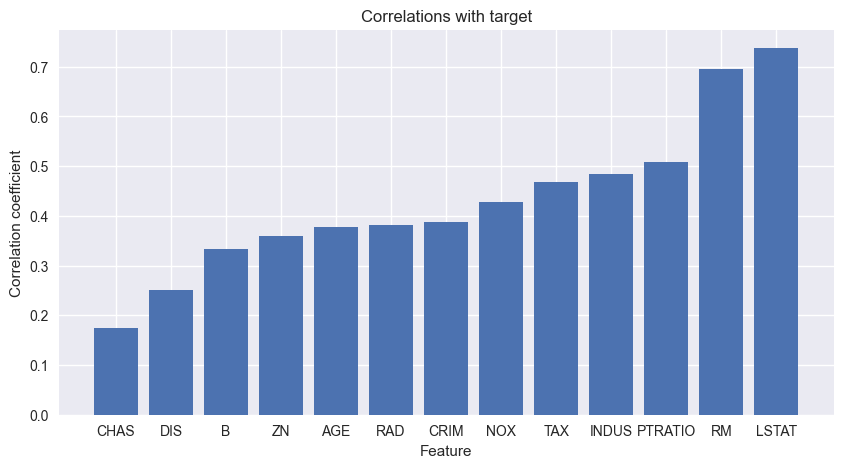

In [61]:
#Вычисляем модуль корреляции
corr_with_target = boston_data.corr()['MEDV'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('MEDV')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Итак, самый коррелированный по модулю с медианной ценой (MEDV) признак — процент населения с низким статусом (LSTAT). Давайте построим линейную регрессию, используя этот признак.

Примечание. Построить линейную регрессию = обучить линейную регрессию = найти её параметры.

Вспоминаем нашу формулу аналитического решения по методу наименьших квадратов:


$$\bar{w} = (X^{T}X)^{-1} X^{T}y = QX^{T}y$$

Что есть X и y? Это матрица из примеров (матрица наблюдений) и вектор правильных ответов к ним соответственно. У нас матрица X — это таблица, состоящая из одного столбца (LSTAT), а y — столбец с медианными ценами (MEDV):

In [62]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов
X.head()
#y.head()

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


Примечание. Двойные квадратные скобки boston_data[['LSTAT']] позволяют выбрать признак из DataFrame, сохранив его в виде таблицы. Это важно, так как в формуле МНК X — это матрица.

У нас есть все компоненты формулы, чтобы найти параметры модели. Давайте напишем функцию linear_regression(), в которой реализуем вычисления коэффициентов. Аргументами функции будут матрица наблюдений X и вектор ответов y, а возвращать она будет вектор параметров w.

Матричные вычисления легче всего реализовать через библиотеку numpy.

Для начала вспомним, что для вычисления свободного члена w0 необходимо добавить в таблицу столбец, полностью состоящий из единиц. Такой столбец можно создать с помощью знакомой нам функции ones() из библиотеки numpy, а присоединить его к таблице X поможет функция column_stack().

Матричное умножение в numpy реализуется с помощью оператора @. Транспонирование осуществляется через .T, а обратная матрица вычисляется с помощью функции inv() из модуля linalg (модуля для линейной алгебры).

In [63]:
def linear_regression(X, y):
    #Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

Осталось только вызвать нашу функцию и передать в неё нашу таблицу примеров X и столбец правильных ответов y. Вычислим вектор параметров и выведем его на экран:

In [64]:
#Вычисляем параметры линейной регрессии
w = linear_regression(X, y)
#Выводим вычисленные значения параметров в виде вектора
print('Vector w: {}'.format(w))
#Выводим параметры с точностью до двух знаков после запятой
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))
# Vector w: [34.55384088 -0.95004935]
# w0: 34.55
# w1: -0.95

Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


Итак, мы получили значения коэффициентов уравнения прямой. С точностью до сотых они равны:

$w_{0} = 34.55$

$w_{1} =−0.95$

А значит сама модель будет иметь вид:

$\hat{y} = 34.55 - 0.95x_{1}$

Самое приятное в модели линейной регрессии — то, что её коэффициенты можно проинтерпретировать. 

Коэффициент w0=34.55 имитирует влияние сторонних факторов, которые не учтены в модели. Это значение медианной цены домов на участке, если бы значение процента населения с низким статусом было равно 0. 

Коэффициент w1=−0.95 означает, на сколько в среднем изменится медианная цена (в тысячах долларов) при увеличении низкостатусного населения на 1 единицу. То есть если количество низкостатусного населения увеличится на 1 %, то медианная цена зданий на участке упадёт на 0.95 тысяч долларов. Можно сказать, что каждый новый процент низкостатусного населения уменьшает медианную цену на 0.95 тысяч долларов.

Теперь, если в данных появится новый участок Бостона с известной долей низкостатусного населения, мы сможем предсказать значение медианной стоимости домов простой подстановкой значений в модель:

In [65]:
#Задаём процент низкостатусного населения
x_example = 5.18 
#Делаем предсказание
y_predict = w[0] + w[1] * x_example
print('Predicted value: {:.2f}'.format(float(y_predict)))
#Predicted value: 29.63

Predicted value: 29.63


Так как мы работаем с одним фактором, то можем построить визуализацию нашей модели.

Давайте напишем функцию plot_regression_2d(), у которой будет три обязательных аргумента (матрица наблюдений X, столбец правильных ответов y и столбец с предсказаниями модели y_pred) и два аргумента по умолчанию (xlabel — подпись оси абсцисс и ylabel — подпись оси ординат).

In [66]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда

Сделаем предсказание для всех объектов из таблицы X, подставив её в модель линейной регрессии с найденными параметрами, и построим график:

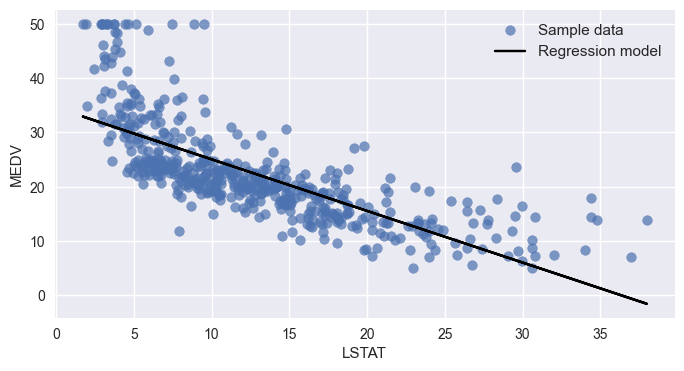

In [67]:
#Делаем предсказание для всех объектов из таблицы
y_predict = w[0] + w[1] * X
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Как и ожидалось, прямая является убывающей (коэффициент w1<0), и, если её продолжить влево, она пересечётся с осью ординат в точке w0=34.55. 

Итак, мы воспользовались формулой для МНК алгоритма и нашли параметры модели линейной регрессии «вручную», реализовав формулу в виде функции. Отметим, что наша функция универсальна: в неё можно подавать не только матрицу X с одним признаком (LSTAT), но и таблицу, содержащую все признаки, описывающие участки.

Конечно же, никто не строит линейную регрессию «руками», используя формулу МНК. Все дата-сайентисты пользуются библиотеками, такими как sklearn. Давайте посмотрим на реализацию ↓

# АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ SKLEARN

Алгоритм построения модели реализован в библиотеке машинного обучения sklearn и находится в модуле linear_model. Давайте импортируем этот модуль:

In [68]:
from sklearn import linear_model

В модуле находится класс LinearRegression, который реализует аналитическое решение линейной регрессии. Для обучения модели необходимо просто вызвать метод fit(), передав в него матрицу наблюдений X и вектор правильных ответов y.

Данный метод реализует формулу метода наименьших квадратов и рассчитает параметры модели самостоятельно. Чтобы получить свободный член $w_{0}$ нужно обратиться по атрибуту intercept_, а вектор параметров  $w_{1}, w_{2}, ..., w_{m}$ будет храниться в атрибуте coef_ (так как у нас один фактор в матрице X, то и коэффициент будет только один):

In [69]:
#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X, y)
 
print('w0: {}'.format(lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm
 
# w0: 34.55384087938311
# w1: [-0.95004935]

w0: 34.5538408793831
w1: [-0.95004935]


Примечание. Обратите внимание, что мы получили ровно те же самые значения для параметров модели, что является вполне ожидаемым, ведь метод fit() у объекта LinearRegression реализует ту же самую формулу МНК, которую мы прописали в функции linear_regression(). Интерпретация коэффициентов остаётся той же.

Модель обучена. А как сделать предсказание? Вручную записывать выражение для модели и подставлять коэффициенты? Конечно же, нет. Для этого есть метод predict(). В него необходимо передать матрицу наблюдений, для которых нужно сделать предсказание.

Давайте сделаем предсказание для всех наших наблюдений из таблицы X и визуализируем результат с помощью нашей функции plot_regression_2d():

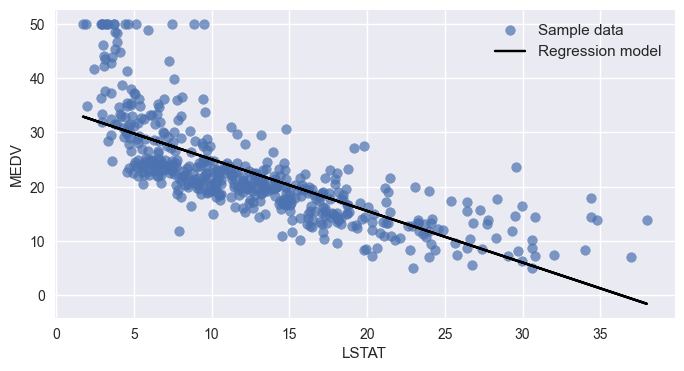

In [70]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Получаем тот же самый график, что мы видели ранее, когда реализовывали линейную регрессию вручную.

А что, если мы хотим построить линейную регрессию, используя всю предоставленную информацию, то есть все 13 признаков? Не проблема! Нужно только расширить матрицу наблюдений X, добавив в неё остальные признаки и снова обучить модель LinearRegression.

Давайте выберем из таблицы boston все столбцы, исключая столбец с целевой переменной (MEDV). Полученную матрицу X и вектор правильных ответов y отправляем в метод fit(), чтобы произвести подгонку и найти параметры модели.

In [71]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X, y)

LinearRegression()

Для удобства составим DataFrame из коэффициентов  $w_{1}, w_{2}, ..., w_{13}$ обученной модели, не забыв добавить к нему строку со свободным членом $w_{0}$:

In [72]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


Итак, мы получили таблицу с признаками из нашего набора данных и коэффициентами, которые им соответствуют.

Каждый из коэффициентов в модели показывает, на сколько в среднем (согласно модели) изменится медианная цена (в тысячах долларов) при увеличении параметра на единицу. Например, если уровень преступности увеличится на один пункт, то медианная цена зданий на участке упадёт на 0.1 тыс. долларов. А вот увеличение среднего количества комнат на участке (RM) на одну единицу повысит медианную цену на 3.8 тыс. долларов.

→ Свободный член (INTERCEPT) всё так же имитирует влияние внешних факторов и носит смысл «поправки» модели относительно медианной стоимости.

Итак, мы с вами построили две модели линейной регрессии: lr_lstat на одном признаке (LSTAT) и lr_full — на всех признаках в данных. Хотелось бы сравнить эти модели по их качеству. Может, нам достаточно только знаний о проценте низкостатусного населения, чтобы предсказать медианную цену?

Самая простая идея — визуализировать ошибки. Давайте построим коробчатые диаграммы ошибок моделей. Ошибки будем считать по формуле:

$$error_{i} = y_{i} - \hat{y_{i}}$$

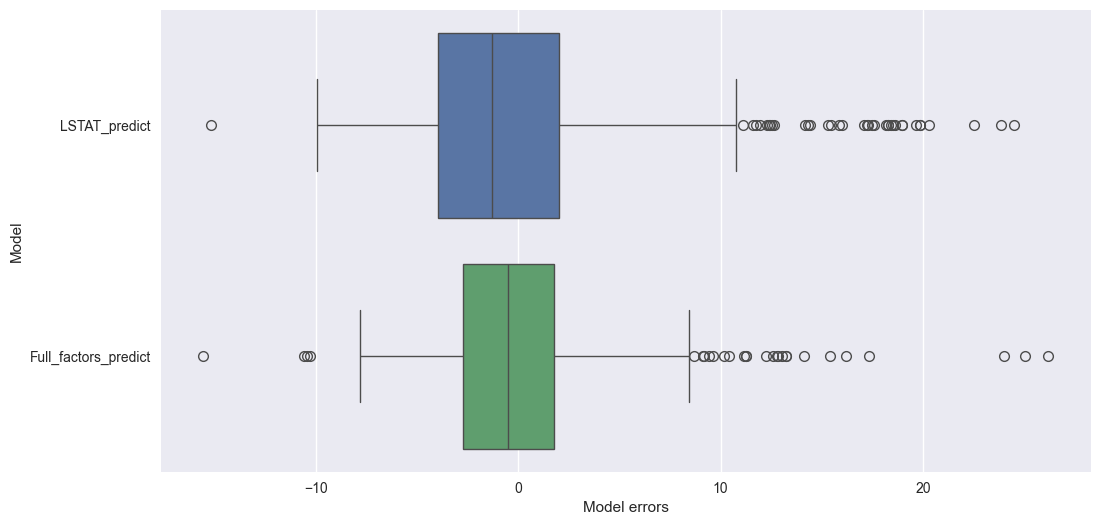

In [73]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Из построенных диаграмм ошибок видно, что разброс ошибок для модели, построенной на всех признаках, ниже (ящик уже и усы короче), и медиана ошибки также более приближена к 0. То есть можно сказать, что визуально качество второй модели выглядит лучше.

На обеих диаграммах присутствуют точки, сильно выбивающиеся за пределы усов. Это наблюдения, для которых модель допустила очень большую ошибку, по сравнению с основной группой.

Можно предположить, что это объекты, для которых гипотеза о линейной зависимости несправедлива, и линейной модели не хватает для предсказания целевой переменной для таких объектов. О том, как справиться с этой проблемой, мы поговорим чуть позже.

Визуализация — это, конечно, хорошо, но, согласитесь, не очень удобно: визуализация не даёт конкретики — только общие представления об ошибках.

Может быть, есть способ описать качество модели каким-то конкретным числом? Да. Этот показатель называется метрикой. 

✍ О метриках регрессии мы поговорим в следующем юните, а пока предлагаем выполнить несколько заданий на закрепление основ работы с линейной регрессией ↓

### Задание 2.7
1 point possible (graded)
В ваших данных появился новый участок со следующими параметрами:

CRIM         0.35114
ZN           0.00000
INDUS        7.38000
CHAS         0.00000
NOX          0.49300
RM           6.04100
AGE         49.90000
DIS          4.72110
RAD          5.00000
TAX        287.00000
PTRATIO     19.60000
B          396.90000
LSTAT        7.70000

Сделайте предсказание медианной стоимости (MEDV) для данного участка c помощью модели lr_full. Введите результат предсказания в тысячах долларов. Ответ округлите до второго знака после точки-разделителя.

22.87

In [74]:
# Создаем словарь с данными
data_ask = {
    'CRIM': [0.35114],
    'ZN': [0.00000],
    'INDUS': [7.38000],
    'CHAS': [0.00000],
    'NOX': [0.49300],
    'RM': [6.04100],
    'AGE': [49.90000],
    'DIS': [4.72110],
    'RAD': [5.00000],
    'TAX': [287.00000],
    'PTRATIO': [19.60000],
    'B': [396.90000],
    'LSTAT': [7.70000]
}

# Создаем DataFrame из словаря
df_ask = pd.DataFrame(data_ask)

y_predict_ask = lr_full.predict(df_ask)

print(round(y_predict_ask[0], 2))

22.87


### Задание 2.8
3 points possible (graded)

Дан набор данных о стартапах и их прибыли (в долларах) в трёх различных штатах США.
Столбцы:

R&D Spend — расходы на исследования.
Administration — административные расходы.
Marketing Spend — расходы на маркетинг.
State — штат.
Profit — прибыль (целевой признак).
Для обучения линейной регрессии используйте R&D Spend, Administration и Marketing Spend. Отделите факторы от целевой переменной.

Обучите модель линейной регрессии методом наименьших квадратов с помощью библиотеки numpy (воспользуйтесь формулой из модуля).

Чему равны коэффициенты линейной регрессии при признаках R&D Spend, Administration и Marketing Spend? Ответ введите с точностью до второго знака после точки-разделителя.

R&D Spend:

In [75]:
startup_data = pd.read_csv('data/50_Startups.csv')
startup_data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [76]:
X2 = startup_data[['R&D Spend', 'Administration', 'Marketing Spend']] #матрица наблюдений
y2 = startup_data['Profit'] #вектор правильных ответов
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [77]:
lr_full_startup = linear_model.LinearRegression()
lr_full_startup.fit(X2, y2)
print(lr_full_startup.coef_)
print(lr_full_startup.intercept_)


print(round(lr_full_startup.coef_[0], 2))
print(round(lr_full_startup.coef_[1], 2))
print(round(lr_full_startup.coef_[2], 2))

print(round(lr_full_startup.intercept_, 2))



[ 0.80571505 -0.02681597  0.02722806]
50122.19298986524
0.81
-0.03
0.03
50122.19


## 3. Метрики регрессии. Недостатки аналитического решения

РАСЧЁТ МЕТРИК НА PYTHON

Настало время проверить качество построенных нами ранее моделей линейной регрессии: lr_lstat и lr_full.

Весь набор функций для вычисления метрик в sklearn находится в модуле metrics. Давайте его импортируем:

from sklearn import metrics

Функции, которые нам понадобятся:

- mean_absolute_error() — расчёт MAE;
- mean_squared_error() — расчёт MSE;
- mean_absolute_percentage_error() — расчёт MAPE;
- r2_score() — расчёт коэффициента детерминации R2.

В каждую из функций достаточно передать правильные ответы и предсказания, и функция вернёт рассчитанную метрику.

Примечание. Для расчёта метрики RMSE нет специальной функции, однако мы знаем, что для её расчёта достаточно извлечь квадратный корень из MSE.

Из-за особенностей реализации функция mean_absolute_percentage_error() возвращает результат не в процентах, а в долях. Чтобы отобразить результат в процентах, необходимо умножить его на 100.

Давайте вычислим метрики и выведем их на экран, округлив до третьего знака после запятой. Начнём с модели lr_lstat: сделаем предсказание на основании признака LSTAT и передадим истинные и предсказанные медианные цены в функции для расчёта метрик:

In [78]:
from sklearn import metrics

In [79]:
#Делаем предсказание по признаку LSTAT
y_predict_lstat = lr_lstat.predict(boston_data[['LSTAT']])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_lstat)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_lstat))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_lstat) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_lstat)))
 
 
# MAE score: 4.505 thou. $
# RMSE score: 6.203 thou. $
# MAPE score: 21.352 %
# R2 score: 0.544

MAE score: 4.505 thou. $
RMSE score: 6.203 thou. $
MAPE score: 21.352 %
R2 score: 0.544


Проделываем ту же самую операцию для второй модели линейной регрессии, lr_full:

In [80]:
#Делаем предсказание по всем признакам
y_predict_full = lr_full.predict(boston_data[features])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_full)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_full))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_full) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_full)))
 

# MAE score: 3.271 thou. $
# RMSE score: 4.679 thou. $
# MAPE score: 16.417 %
# R2 score: 0.741

MAE score: 3.271 thou. $
RMSE score: 4.679 thou. $
MAPE score: 16.417 %
R2 score: 0.741


Сравним полученные результаты:

MAE: в среднем первая модель ошибается на  4.505 тыс. долларов, а вторая — на 3.271 тыс. долларов.
RMSE: среднеквадратичное отклонение первой модели от истинных ответов составляет 6.203 тыс. долларов, а второй — 4.679.
MAPE: первая модель ошибается на 21.352 %, а вторая — на 16.417 %.
R2: доля объясняемой информации (дисперсии), которую улавливает первая модель, — 0.544, а вторая — 0.741.
Очевидно, что по всем метрикам вторая модель, построенная на основе всех признаков в данных, превосходит первую.

✍ Следует отметить, что для задач регрессии существует множество метрик, и мы рассмотрели только наиболее распространённые из них. Весь список метрик и их расчёт в sklearn вы можете найти здесь.

### Задание 3.2
1 point possible (graded)

У вас есть истинные ответы 
y_true = [1.23, 2.35, 2.75] 
и предсказания модели 
y_pred = [1.01, 12.3, 2.74]. 

Посчитайте метрику RMSE, ответ округлите до двух знаков после точки-разделителя.

RMSE score: 5.75 thou. $

In [82]:
y_true = [1.23, 2.35, 2.75] 
y_pred = [1.01, 12.3, 2.74]

print('RMSE score: {:.2f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y_true, y_pred))))


RMSE score: 5.75 thou. $


### Задание 3.3
1 point possible (graded)

Чему равен коэффициент детерминации на следующих данных?
Истинные ответы: 
y_true = [22.4, 20.6, 23.9, 22.0, 11.9]

Предсказанные ответы: 
y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]

Ответ округлите до двух знаков после точки-разделителя.

Пример ввода ответа: 3.14

R2 score: 0.71

In [83]:
#Истинные ответы: 
y_true = [22.4, 20.6, 23.9, 22.0, 11.9]

#Предсказанные ответы: 
y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]

#Рассчитываем коэффициент детерминации
print('R2 score: {:.2f}'.format(metrics.r2_score(y_true, y_pred)))

R2 score: 0.71
